In [5]:
%load_ext autoreload 
%autoreload 2

import os
import gpflow
import numpy as np
import scipy.io
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn2
plt.style.use('ggplot')
mpl.rcParams['pgf.rcfonts'] = False

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# this doesn't work for some reason...
# remove the default one just in case
# gpflow.get_session().close()

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
# config = config=tf.ConfigProto(gpu_options=gpu_options)
# config.gpu_options.allow_growth=True
# sess = gpflow.session_manager.tf.Session(config=config)
# sess.as_default()
# print(sess)

from gp_svgp import GP_MNIST_SVGP
from mnist_cnn import CNN_MNIST
from mnist_svm import SVM_MNIST
from hybrid_mnist import Hybrid_MNIST
from mnist_preprocessing import get_mnist_data, preprocess_images

#from plotting import Plotter

/local/scratch/js2173/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
class Data(object):
    def __init__(self):
        self.data = {}
    def write(self, path, value):
        ptr = self.data
        for key in path[:-1]:
            if key not in ptr:
                ptr[key] = {}
            ptr = ptr[key]
        ptr[path[-1]] = value
    def dump(self, name, path="../data/evaluation/"):
        np.save(path + name, self.data)
        print("Saved to file, emptying data container")
        self.data = {}

data = Data()

In [7]:
# Standard MNIST test data
((_, mnist_test_imgs), (ys_train_onehot, ys_test_onehot)) = get_mnist_data()
mnist_train_features = np.genfromtxt("../data/mnist_train_features.csv", delimiter=",")
mnist_test_features = np.genfromtxt("../data/mnist_test_features.csv", delimiter=",")

ys_train = np.argmax(ys_train_onehot, axis=1)
ys_test = np.argmax(ys_test_onehot, axis=1)
# easier to remember handle
correct_classes = ys_test
n = len(ys_test)

In [8]:
cnn_model = CNN_MNIST(isolate=True) # isolate sessions # get default pretrained, saved CNN

In [9]:
svm_model = SVM_MNIST(mnist_train_features, ys_train, nb_classes=10, retrain=False)

Loading SVM from ../models/svm/svm_SVM classifier_model.pkl


In [10]:

hybrid_models = []
#for tol in np.arange(0, 2.0, 0.5):
#    hybrid_models.append(Hybrid_MNIST(accept_cnn_tolerance = tol))
#for tol in np.arange(0.1, 0.6, 0.1):
#    hybrid_models.append(Hybrid_MNIST(accept_cnn_tolerance = tol, stronger_criterion=True))
hybrid_models.append(Hybrid_MNIST(accept_cnn_tolerance = 0.2, stronger_criterion=True))
#hybrid_models.append(Hybrid_MNIST(accept_cnn_tolerance = 0.275, stronger_criterion=True))
#hybrid_models.append(Hybrid_MNIST(accept_cnn_tolerance = 0.75, stronger_criterion=True))

In [11]:
# instantiate models we want to test
# only one at a time here to avoid interference

get_gp_model = [
                lambda: GP_MNIST_SVGP(kernel=gpflow.kernels.Polynomial, 
                     whitevar=0.1,
                     latent_split=25,
                     whiten=True,
                     q_diag=True,
                     minibatch=8000,
                     whitevar_trainable=False,
                     feat_trainable=True,
                     name="Poly Kernel GP",
                     retrain=False),
                lambda: GP_MNIST_SVGP(kernel=[gpflow.kernels.Linear, gpflow.kernels.Matern32], 
                     whitevar=0.1,
                     latent_split=25,
                     whiten=True,
                     q_diag=True,
                     minibatch=8000,
                     whitevar_trainable=False,
                     feat_trainable=True,
                     name="Linear * Matern32 Kernel GP",
                     retrain=False),
                lambda: GP_MNIST_SVGP(kernel=[gpflow.kernels.Matern12], 
                     whitevar=0.1,
                     latent_split=25,
                     whiten=True,
                     q_diag=True,
                     minibatch=8000,
                     whitevar_trainable=False,
                     feat_trainable=True,
                     name="Matern12 Kernel GP",
                     retrain=False),
    
    
    
#     lambda: GP_MNIST_SVGP(kernel=[gpflow.kernels.Linear, gpflow.kernels.Matern32], 
#                          whitevar=0.1,
#                          latent_split=25,
#                          whiten=True,
#                          q_diag=True,
#                          minibatch=8000,
#                          whitevar_trainable=False,
#                          feat_trainable=True,
#                          name="Linear * Matern32 Kernel params2 GP",
#                          retrain=False),
#                 lambda: GP_MNIST_SVGP(kernel=[gpflow.kernels.Polynomial, gpflow.kernels.Linear],
#                          whitevar=0.1,
#                          latent_split=25,
#                          whiten=True,
#                          q_diag=True,
#                          minibatch=8000,
#                          whitevar_trainable=False,
#                          feat_trainable=True,
#                          name="Poly * Linear Kernel GP",
#                          retrain=False),
#                     lambda: GP_MNIST_SVGP(kernel=[gpflow.kernels.Polynomial, gpflow.kernels.Matern12],
#                          whitevar=0.1,
#                          latent_split=25,
#                          whiten=True,
#                          q_diag=True,
#                          minibatch=8000,
#                          whitevar_trainable=False,
#                          feat_trainable=True,
#                          name="Poly * Matern12 Kernel GP",
#                          retrain=False),
#                     lambda: GP_MNIST_SVGP(kernel=[gpflow.kernels.Polynomial, gpflow.kernels.Matern32],
#                          whitevar=0.1,
#                          latent_split=25,
#                          whiten=True,
#                          q_diag=True,
#                          minibatch=8000,
#                          whitevar_trainable=False,
#                          feat_trainable=True,
#                          name="Poly * Matern32 Kernel GP",
#                          retrain=False)
#                 lambda: GP_MNIST_SVGP(kernel=[gpflow.kernels.Linear, gpflow.kernels.Matern52], 
#                          whitevar=0.1,
#                          latent_split=25,
#                          whiten=True,
#                          q_diag=True,
#                          minibatch=8000,
#                          whitevar_trainable=False,
#                          feat_trainable=True,
#                          name="Linear * Matern52 Kernel params2 GP",
#                          retrain=False),
#                          lambda: GP_MNIST_SVGP(kernel=gpflow.kernels.Linear, 
#                          whitevar=0.1,
#                          latent_split=25,
#                          whiten=True,
#                          q_diag=True,
#                          minibatch=8000,
#                          whitevar_trainable=False,
#                          feat_trainable=True,
#                          name="Linear Kernel GP", 
#                          retrain=False),
#                 lambda: GP_MNIST_SVGP(kernel=gpflow.kernels.Matern12, 
#                          whitevar=0.1,
#                          latent_split=25,
#                          whiten=True,
#                          q_diag=True,
#                          minibatch=8000,
#                          whitevar_trainable=False,
#                          feat_trainable=True,
#                          name="Matern12 Kernel GP",
#                          retrain=False),
#                 lambda: GP_MNIST_SVGP(kernel=gpflow.kernels.Matern32, 
#                          whitevar=0.1,
#                          latent_split=25,
#                          whiten=True,
#                          q_diag=True,
#                          minibatch=8000,
#                          whitevar_trainable=False,
#                          feat_trainable=True,
#                          name="Matern32 Kernel GP",
#                          retrain=False),
#                 lambda: GP_MNIST_SVGP(kernel=gpflow.kernels.Matern52, 
#                          whitevar=0.1,
#                          latent_split=25,
#                          whiten=True,
#                          q_diag=True,
#                          minibatch=8000,
#                          whitevar_trainable=False,
#                          feat_trainable=True,
#                          name="Matern52 Kernel GP",
#                          retrain=False),
#                 lambda: GP_MNIST_SVGP(kernel=gpflow.kernels.RBF, 
#                          whitevar=0.1,
#                          latent_split=25,
#                          whiten=True,
#                          q_diag=True,
#                          minibatch=8000,
#                          whitevar_trainable=False,
#                          feat_trainable=True,
#                          name="RBF Kernel GP",
#                          retrain=False)
                ]


In [8]:
record_in = 'Standard MNIST'

# prediction accuracies
subkey = 'accuracy'


#CNN
mnist_cnn_preds = cnn_model.predict_img_batch(mnist_test_imgs)
mnist_cnn_classes = np.argmax(mnist_cnn_preds, axis=1)
mnist_cnn_correct = correct_classes == mnist_cnn_classes
mnist_cnn_accuracy = np.count_nonzero(mnist_cnn_correct) / n
print("CNN accuracy: ", mnist_cnn_accuracy)
data.write([record_in, subkey, cnn_model.name],mnist_cnn_accuracy)

# SVM
mnist_svm_classes = svm_model.predict_batch(mnist_test_features)
mnist_svm_correct = correct_classes == mnist_svm_classes
mnist_svm_accuracy = np.count_nonzero(mnist_svm_correct) / n
print("SVM accuracy: ", mnist_svm_accuracy)
data.write([record_in, subkey, svm_model.name], mnist_svm_accuracy)


CNN accuracy:  0.9911
SVM accuracy:  0.9937


Initialized Poly Kernel GP
Loading GP model from file ../models/gp/Poly Kernel GP_model.npy
Instantiated Poly Kernel GP
Poly Kernel GP accuracy:  0.9891
Number incorrect in both models: 73
Number CNN incorrect but not GP: 16
Number GP incorrect but not CNN: 36
Number GP Correct but not CNN 16
Number CNN Correct but not GP 36


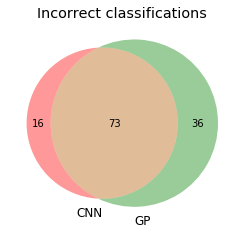

Hybrid(GP: Poly Kernel GP) accuracy: 0.989
Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy
Instantiated Linear * Matern32 Kernel GP
Linear * Matern32 Kernel GP accuracy:  0.9914
Number incorrect in both models: 73
Number CNN incorrect but not GP: 16
Number GP incorrect but not CNN: 13
Number GP Correct but not CNN 16
Number CNN Correct but not GP 13


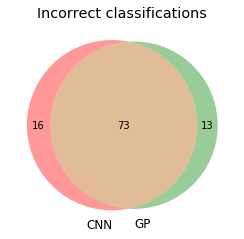

Hybrid(GP: Linear * Matern32 Kernel GP) accuracy: 0.9914
Initialized Matern12 Kernel GP
Loading GP model from file ../models/gp/Matern12 Kernel GP_model.npy
Instantiated Matern12 Kernel GP
Matern12 Kernel GP accuracy:  0.9903
Number incorrect in both models: 74
Number CNN incorrect but not GP: 15
Number GP incorrect but not CNN: 23
Number GP Correct but not CNN 15
Number CNN Correct but not GP 23


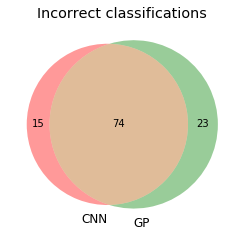

Hybrid(GP: Matern12 Kernel GP) accuracy: 0.9903


In [9]:
accuracies = {}
accuracies[cnn_model.name] = mnist_cnn_accuracy # save for plotting
# GP
for gp_model_getter in get_gp_model:
    gp_model = gp_model_getter()
    print("Instantiated", gp_model.name)
    mnist_gp_mu, mnist_gp_var = gp_model.predict_batch(mnist_test_features)
    mnist_gp_classes = np.argmax(mnist_gp_mu, axis=1)
    mnist_gp_correct = correct_classes == mnist_gp_classes
    mnist_gp_accuracy = np.count_nonzero(mnist_gp_correct) / n
    accuracies[gp_model.name] = mnist_gp_accuracy
    print(gp_model.name, "accuracy: ", mnist_gp_accuracy)
    data.write([record_in, subkey, gp_model.name], mnist_gp_accuracy)

    
    # analyze the overlap in mis-classifications
    mnist_cnn_incorrect = correct_classes != mnist_cnn_classes
    mnist_gp_incorrect = correct_classes != mnist_gp_classes
    mnist_overlap_incorrect = mnist_cnn_incorrect & mnist_gp_incorrect
    both_incorrect = np.count_nonzero(mnist_overlap_incorrect)
    print("Number incorrect in both models:", both_incorrect)
    print("Number CNN incorrect but not GP:", np.count_nonzero(mnist_cnn_incorrect) -  both_incorrect)
    print("Number GP incorrect but not CNN:", np.count_nonzero(mnist_gp_incorrect) -  both_incorrect)
    both_incorrect_imgs = mnist_test_imgs[mnist_overlap_incorrect]
    #plt.imshow(both_incorrect_imgs[0])
    
    gp_correct_not_cnn = mnist_gp_correct & ~mnist_cnn_correct
    print("Number GP Correct but not CNN", np.count_nonzero(gp_correct_not_cnn))
    
    cnn_correct_not_gp = mnist_cnn_correct & ~mnist_gp_correct
    print("Number CNN Correct but not GP", np.count_nonzero(cnn_correct_not_gp))


    plt.figure(figsize=(4,4))
    v = venn2(subsets=(np.count_nonzero(gp_correct_not_cnn),np.count_nonzero(cnn_correct_not_gp), both_incorrect), set_labels = ('CNN', 'GP', 'Both'))
    plt.title("Incorrect classifications")
    #plt.annotate('Unknown set', xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
    #             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
    #             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
    plt.savefig('../results/figs/mnist/venn_' + gp_model.name + '.pdf', bbox_inches='tight')
    plt.show()
    
    for hybrid in hybrid_models:
        name = hybrid.name + "(GP: {})".format(gp_model.name)
        hybrid_pred, hybrid_mus, hybrid_vars = hybrid.combine_predictions(mnist_cnn_preds, mnist_gp_mu, mnist_gp_var, verbose=False)
        hybrid_classes = hybrid_pred[:, 1].astype(int)
        hybrid_correct = correct_classes == hybrid_classes
        #print(hybrid_correct)
        hybrid_accuracy = np.count_nonzero(hybrid_correct) / n
        print(name, "accuracy:", hybrid_accuracy)
        data.write([record_in, subkey, name], hybrid_accuracy)
        accuracies[hybrid.name] = hybrid_accuracy
    del gp_model


In [15]:
def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height*1.0005,
                '%.2f%%' % float(height),
                ha='center', va='bottom')

In [10]:
accuracies

{'CNN classifier': 0.9911,
 'Hybrid': 0.9903,
 'Linear * Matern32 Kernel GP': 0.9914,
 'Matern12 Kernel GP': 0.9903,
 'Poly Kernel GP': 0.9891}

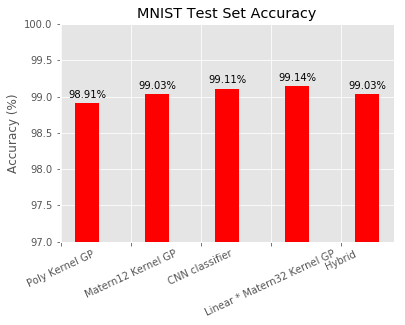

In [11]:
# Plot MNIST performance
#del accuracies['Hybrid'] # ignore for now


        
# some manual fiddling to rename then the following
xs, values = list(zip(*list(accuracies.items())))
ind = np.arange(len(xs))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, 100*np.array(values), width, color='r')
autolabel(rects1, ax)
# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy (%)')
ax.set_title('MNIST Test Set Accuracy')
ax.set_xticks(ind + width / 2 - 0.55)
ax.set_xticklabels(xs)
ax.set_ylim([97.0, 100.0])
plt.xticks(rotation=25)
plt.savefig('../results/figs/mnist/accuracies.pdf', bbox_inches='tight')
plt.show()

In [12]:
print(hybrid_classes.shape)
print(correct_classes.shape)
print(hybrid_classes == correct_classes)

(10000,)
(10000,)
[ True  True  True ...  True  True  True]


In [13]:
def plot_instance(axis, classes, correct_class, mu, var, width=0.3):
    v = np.sqrt(var)
    rects1 = axis.bar(classes, mu, width, color='r', yerr=v)
    rects2 = axis.bar(correct_class, mu[correct_class], width, color='g', yerr=v[correct_class])


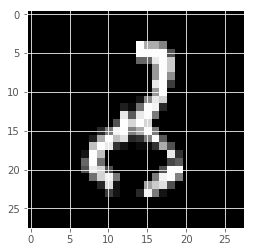

GP Predictions: [  1.11111111e-04   1.11111116e-04   7.03941425e-01   1.55959076e-01
   1.11111111e-04   1.11111111e-04   1.11111111e-04   1.11111111e-04
   1.38522876e-01   1.11111111e-04]


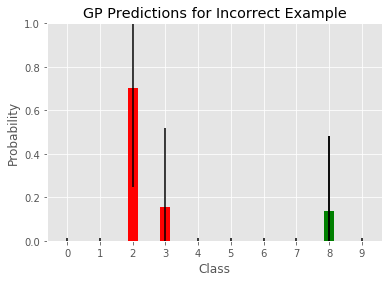

CNN Predictions: [  1.33762839e-07   1.94914846e-05   6.54773951e-01   7.53047317e-02
   2.21210627e-07   8.21320043e-08   1.11097529e-06   1.35922946e-07
   2.69900054e-01   5.16141512e-08]


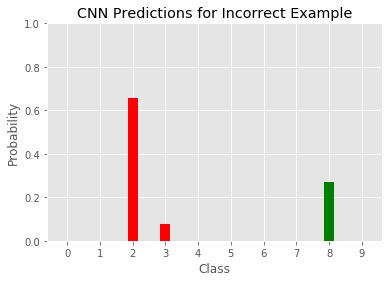

In [72]:


classes = np.arange(mnist_gp_mu.shape[-1]) # 0 -> 9
# save some examples for both failing
index = 5
plt.show()
plt.style.use('default')
plt.imshow(both_incorrect_imgs[index].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.savefig('../results/figs/mnist/both_incorrect_example_linear.pdf', bbox_inches='tight')
plt.show()
plt.style.use('ggplot')


print("GP Predictions:", mnist_gp_mu[mnist_overlap_incorrect][index])
correct_class = correct_classes[mnist_overlap_incorrect][index]
plot_instance(plt, classes, correct_class, mnist_gp_mu[mnist_overlap_incorrect][index], mnist_gp_var[mnist_overlap_incorrect][index], width=0.3)
plt.xticks(classes)
plt.ylim([0.0, 1.0])
plt.title("GP Predictions for Incorrect Example")
plt.xlabel("Class")
plt.ylabel("Probability")
plt.savefig('../results/figs/mnist/both_incorrect_gp_linear_probs.pdf', bbox_inches='tight')
plt.show()

print("CNN Predictions:", mnist_cnn_preds[mnist_overlap_incorrect][index])
plot_instance(plt, classes, correct_class, mnist_cnn_preds[mnist_overlap_incorrect][index], [0]*10, width=0.3)
plt.xticks(classes)
plt.ylim([0.0, 1.0])

plt.title("CNN Predictions for Incorrect Example")
plt.xlabel("Class")
plt.ylabel("Probability")
plt.savefig('../results/figs/mnist/both_incorrect_cnn_probs.pdf', bbox_inches='tight')
plt.show()

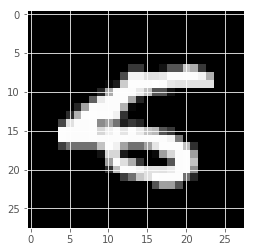

GP Predictions: [  1.11111224e-04   1.11111111e-04   1.11111126e-04   1.11111111e-04
   1.11112044e-04   6.20068303e-01   3.78225716e-01   1.11111111e-04
   1.29380687e-04   1.11111111e-04]


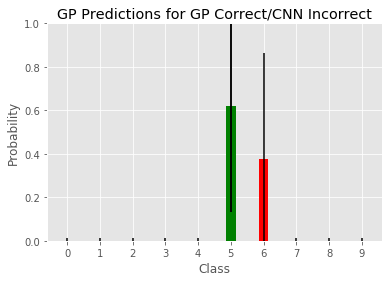

CNN Predictions: [  4.65367593e-05   1.73398675e-07   2.29464121e-07   1.63638241e-08
   2.12655832e-05   4.44226146e-01   5.53724527e-01   5.49633516e-12
   1.98115641e-03   2.08917221e-08]


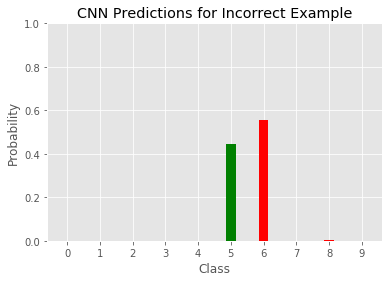

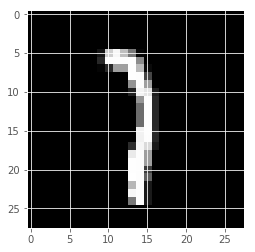

GP Predictions: [  1.11111111e-04   5.98790426e-01   1.59388554e-04   1.11111119e-04
   1.11111111e-04   1.11111111e-04   1.11111111e-04   3.99473582e-01
   1.11112173e-04   1.11111113e-04]


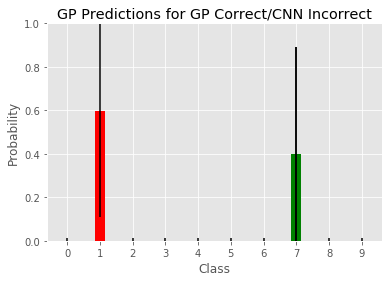

CNN Predictions: [  9.08331344e-07   3.35291475e-01   8.69253185e-03   1.20929588e-04
   2.23420830e-06   1.61058642e-06   8.40219343e-08   6.55311942e-01
   5.42545458e-04   3.57594035e-05]


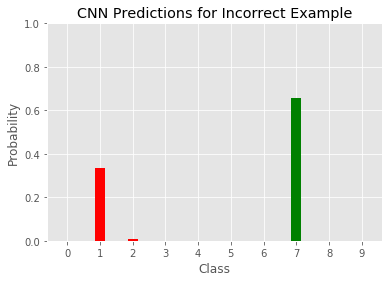

In [76]:

#gp_correct_not_cnn
#cnn_correct_not_gp

classes = np.arange(mnist_gp_mu.shape[-1]) # 0 -> 9
# save some examples for one failing but not the other
index = 6 # 6 demonstrates where might gain with a hybrid model

plt.style.use('default')
plt.imshow(mnist_test_imgs[gp_correct_not_cnn][index].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.savefig('../results/figs/mnist/cnn_incorrect_only_example_linear.pdf', bbox_inches='tight')
plt.show()
plt.style.use('ggplot')


print("GP Predictions:", mnist_gp_mu[gp_correct_not_cnn][index])
correct_class = correct_classes[gp_correct_not_cnn][index]
plot_instance(plt, classes, correct_class, mnist_gp_mu[gp_correct_not_cnn][index], mnist_gp_var[gp_correct_not_cnn][index], width=0.3)
plt.xticks(classes)
plt.ylim([0.0, 1.0])
plt.title("GP Predictions for GP Correct/CNN Incorrect")
plt.xlabel("Class")
plt.ylabel("Probability")
plt.savefig('../results/figs/mnist/cnn_incorrect_only_gp_linear_probs.pdf', bbox_inches='tight')
plt.show()

print("CNN Predictions:", mnist_cnn_preds[gp_correct_not_cnn][index])
plot_instance(plt, classes, correct_class, mnist_cnn_preds[gp_correct_not_cnn][index], [0]*10, width=0.3)
plt.xticks(classes)
plt.ylim([0.0, 1.0])

plt.title("CNN Predictions for Incorrect Example")
plt.xlabel("Class")
plt.ylabel("Probability")
plt.savefig('../results/figs/mnist/cnn_incorrect_only_cnn_probs.pdf', bbox_inches='tight')
plt.show()


#--- CNN only correct Example
plt.imshow(mnist_test_imgs[cnn_correct_not_gp][index].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.savefig('../results/figs/mnist/gp_incorrect_only_example_linear.pdf', bbox_inches='tight')
plt.show()

print("GP Predictions:", mnist_gp_mu[cnn_correct_not_gp][index])
correct_class = correct_classes[cnn_correct_not_gp][index]
plot_instance(plt, classes, correct_class, mnist_gp_mu[cnn_correct_not_gp][index], mnist_gp_var[cnn_correct_not_gp][index], width=0.3)
plt.xticks(classes)
plt.ylim([0.0, 1.0])
plt.title("GP Predictions for GP Correct/CNN Incorrect")
plt.xlabel("Class")
plt.ylabel("Probability")
plt.savefig('../results/figs/mnist/gp_incorrect_only_gp_linear_probs.pdf', bbox_inches='tight')
plt.show()

print("CNN Predictions:", mnist_cnn_preds[cnn_correct_not_gp][index])
plot_instance(plt, classes, correct_class, mnist_cnn_preds[cnn_correct_not_gp][index], [0]*10, width=0.3)
plt.xticks(classes)
plt.ylim([0.0, 1.0])

plt.title("CNN Predictions for Incorrect Example")
plt.xlabel("Class")
plt.ylabel("Probability")
plt.savefig('../results/figs/mnist/gp_incorrect_only_cnn_probs.pdf', bbox_inches='tight')
plt.show()

In [11]:
data.dump("_".join([record_in, subkey]))

Saved to file, emptying data container


In [161]:
# ---- White Noise + NMNIST ----

# Preprocess the N-MNIST data just like standard MNIST
nmnist_noisy = scipy.io.loadmat('../data/raw/n-mnist/nmnist-awgn.mat')

awgn_x_test = preprocess_images(nmnist_noisy['test_x'])
awgn_y_test_onehot = nmnist_noisy['test_y']
awgn_y_test = np.argmax(awgn_y_test_onehot, axis=1)
awgn_correct_classes = awgn_y_test

In [162]:
record_in = 'MNIST + AWGN'
subkey = 'Accuracy'

awgn_feats = cnn_model.extract_features(awgn_x_test)

#CNN
awgn_cnn_preds = cnn_model.predict_img_batch(awgn_x_test)
awgn_cnn_classes = np.argmax(awgn_cnn_preds, axis=1)
awgn_cnn_correct = awgn_correct_classes == awgn_cnn_classes
awgn_cnn_accuracy = np.count_nonzero(awgn_cnn_correct) / n
print("CNN accuracy: ", awgn_cnn_accuracy)
data.write([record_in, subkey, cnn_model.name], awgn_cnn_accuracy)

# SVM
awgn_svm_classes = svm_model.predict_batch(awgn_feats)
awgn_svm_correct = awgn_correct_classes == awgn_svm_classes
awgn_svm_accuracy = np.count_nonzero(awgn_svm_correct) / n
print("SVM accuracy: ", awgn_svm_accuracy)
data.write([record_in, subkey, svm_model.name], awgn_svm_accuracy)

CNN accuracy:  0.9538
SVM accuracy:  0.962


In [163]:
accuracies = {}
accuracies[cnn_model.name] = awgn_cnn_accuracy # save for plotting
# GP
for gp_model_getter in get_gp_model:
    gp_model = gp_model_getter()
    print("Instantiated", gp_model.name)
    awgn_gp_mu, awgn_gp_var = gp_model.predict_batch(awgn_feats)
    awgn_gp_classes = np.argmax(awgn_gp_mu, axis=1)
    awgn_gp_correct = awgn_correct_classes == awgn_gp_classes
    awgn_gp_accuracy = np.count_nonzero(awgn_gp_correct) / n
    print(gp_model.name, "accuracy: ", awgn_gp_accuracy)
    accuracies[gp_model.name] = awgn_gp_accuracy
    data.write([record_in, subkey, gp_model.name], awgn_gp_accuracy)

    for hybrid in hybrid_models:
        name = hybrid.name + "(GP: {})".format(gp_model.name)
        hybrid_pred, hybrid_mus, hybrid_vars = hybrid.combine_predictions(awgn_cnn_preds, awgn_gp_mu, awgn_gp_var)
        hybrid_classes = hybrid_pred[:, 1]
        hybrid_correct = awgn_correct_classes == hybrid_classes
        hybrid_accuracy = np.count_nonzero(hybrid_correct) / n
        
        if 'Matern32' in gp_model.name:
            accuracies[hybrid.name] = hybrid_accuracy
        print(name, "accuracy:", hybrid_accuracy)
        data.write([record_in, subkey, name], hybrid_accuracy)
    del gp_model # Clear TF sessions

Initialized Poly Kernel GP
Loading GP model from file ../models/gp/Poly Kernel GP_model.npy
Instantiated Poly Kernel GP
Poly Kernel GP accuracy:  0.9468
Hybrid(GP: Poly Kernel GP) accuracy: 0.9473
Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy
Instantiated Linear * Matern32 Kernel GP
Linear * Matern32 Kernel GP accuracy:  0.9613
Hybrid(GP: Linear * Matern32 Kernel GP) accuracy: 0.9619
Initialized Matern12 Kernel GP
Loading GP model from file ../models/gp/Matern12 Kernel GP_model.npy
Instantiated Matern12 Kernel GP
Matern12 Kernel GP accuracy:  0.964
Hybrid(GP: Matern12 Kernel GP) accuracy: 0.9638


In [16]:
def make_histogram(values, start=0.0, end=None, bins=10, plot=True, 
                   x_label=None, y_label=None, title=None, color=None,
                   width=None, density=False, cum=False, save=None,
                   legend=[], legend_loc="upper left"):
    if end is None:
        max_value = values.max()
    else:
        max_value = end
    if width is None:
        plotted = plt.hist(values, bins, range=(start, max_value), density=density, cumulative=cum, color=color)
    else:
        plotted = plt.hist(values, bins, range=(start, max_value), width=width, density=density, cumulative=cum, color=color)
    if plot:
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend(legend, loc=legend_loc,
                   fontsize=8)
        
        if save:
            #use save as the path
            plt.savefig(save, bbox_inches='tight')

Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy


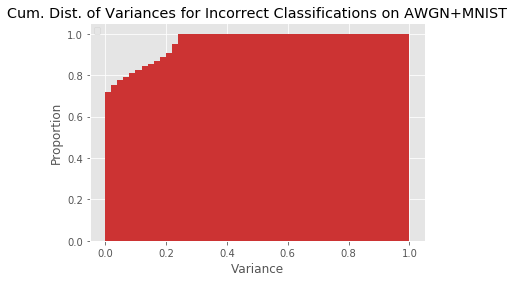

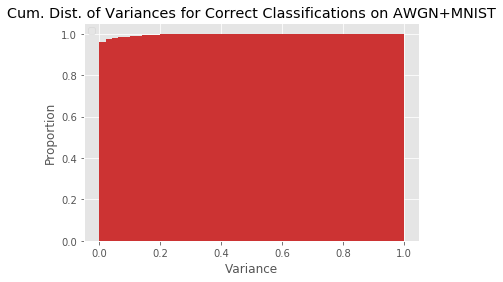

In [170]:
combined_model = get_gp_model[1]()
awgn_gp_mu, awgn_gp_var = combined_model.predict_batch(awgn_feats)
awgn_gp_classes = np.argmax(awgn_gp_mu, axis=1)
awgn_gp_correct = awgn_correct_classes == awgn_gp_classes



correct_mus, correct_vars = awgn_gp_mu[awgn_gp_correct], awgn_gp_var[awgn_gp_correct]
incorrect_mus, incorrect_vars = awgn_gp_mu[~awgn_gp_correct], awgn_gp_var[~awgn_gp_correct]

make_histogram(incorrect_vars.reshape(-1), 
               bins=50, 
               end=1.0, 
               density=True, 
               cum=True, 
               x_label="Variance",
               y_label="Proportion", 
               color=[0.8, 0.2, 0.2],
               legend_loc="upper left",
               title="Cum. Dist. of Variances for Incorrect Classifications on AWGN+MNIST",
               save='../results/figs/nmnist/awgn_incorrect_variances_combined.pdf')
plt.show()
make_histogram(correct_vars.reshape(-1), 
               bins=50, 
               end=1.0, 
               density=True, 
               cum=True, 
               x_label="Variance",
               y_label="Proportion", 
               color=[0.8, 0.2, 0.2],
               legend_loc="upper left",
               title="Cum. Dist. of Variances for Correct Classifications on AWGN+MNIST",
               save='../results/figs/nmnist/awgn_correct_variances_combined.pdf')
plt.show()


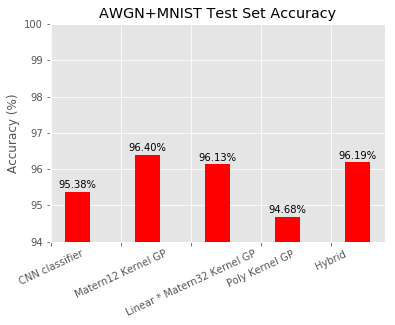

In [165]:
# Plot AWGN NMNIST performance

        
# some manual fiddling to rename then the following
xs, values = list(zip(*list(accuracies.items())))
ind = np.arange(len(xs))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, 100*np.array(values), width, color='r')
autolabel(rects1, ax)
# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy (%)')
ax.set_title('AWGN+MNIST Test Set Accuracy')
ax.set_xticks(ind + width / 2 - 0.55)
ax.set_xticklabels(xs)
ax.set_ylim([94.0, 100.0])
plt.xticks(rotation=25)
plt.savefig('../results/figs/nmnist/awgn_accuracies.pdf', bbox_inches='tight')
plt.show()

In [32]:
data.dump("_".join([record_in, subkey]))

Saved to file, emptying data container


In [155]:
nmnist_blur = scipy.io.loadmat('../data/raw/n-mnist/nmnist-blur.mat')
blur_x_test = preprocess_images(nmnist_blur['test_x'])
blur_y_test_onehot = nmnist_blur['test_y']
blur_y_test = np.argmax(blur_y_test_onehot, axis=1)
blur_correct_classes = blur_y_test

blur_feats = cnn_model.extract_features(blur_x_test)

In [156]:
record_in = 'MNIST + blur'
subkey = 'Accuracy'

blur_feats = cnn_model.extract_features(blur_x_test)

#CNN
blur_cnn_preds = cnn_model.predict_img_batch(blur_x_test)
blur_cnn_classes = np.argmax(blur_cnn_preds, axis=1)
blur_cnn_correct = blur_correct_classes == blur_cnn_classes
blur_cnn_accuracy = np.count_nonzero(blur_cnn_correct) / n
print("CNN accuracy: ", blur_cnn_accuracy)
data.write([record_in, subkey, cnn_model.name], blur_cnn_accuracy)

# SVM
blur_svm_classes = svm_model.predict_batch(blur_feats)
blur_svm_correct = blur_correct_classes == blur_svm_classes
blur_svm_accuracy = np.count_nonzero(blur_svm_correct) / n
print("SVM accuracy: ", blur_svm_accuracy)
data.write([record_in, subkey, svm_model.name], blur_svm_accuracy)

CNN accuracy:  0.9458
SVM accuracy:  0.9279


In [173]:
accuracies = {}
accuracies[cnn_model.name] = blur_cnn_accuracy # save for plotting

# GP
for gp_model_getter in get_gp_model:
    gp_model = gp_model_getter()
    print("Instantiated", gp_model.name)
    blur_gp_mu, blur_gp_var = gp_model.predict_batch(blur_feats)
    blur_gp_classes = np.argmax(blur_gp_mu, axis=1)
    blur_gp_correct = blur_correct_classes == blur_gp_classes
    blur_gp_accuracy = np.count_nonzero(blur_gp_correct) / n
    print(gp_model.name, "accuracy: ", blur_gp_accuracy)

    accuracies[gp_model.name] = blur_gp_accuracy

    data.write([record_in, subkey, gp_model.name], blur_gp_accuracy)

    for hybrid in hybrid_models:
        name = hybrid.name + "(GP: {})".format(gp_model.name)
        hybrid_pred, hybrid_mus, hybrid_vars = hybrid.combine_predictions(blur_cnn_preds, blur_gp_mu, blur_gp_var)
        hybrid_classes = hybrid_pred[:, 1]
        hybrid_correct = blur_correct_classes == hybrid_classes
        hybrid_accuracy = np.count_nonzero(hybrid_correct) / n
        print(name, "accuracy:", hybrid_accuracy)
        data.write([record_in, subkey, name], hybrid_accuracy)
        if 'Matern32' in gp_model.name:
            accuracies[hybrid.name] = hybrid_accuracy
    del gp_model # Clear TF session, graph (hopefully)

Initialized Poly Kernel GP
Loading GP model from file ../models/gp/Poly Kernel GP_model.npy
Instantiated Poly Kernel GP
Poly Kernel GP accuracy:  0.9339
Hybrid(GP: Poly Kernel GP) accuracy: 0.9346
Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy
Instantiated Linear * Matern32 Kernel GP
Linear * Matern32 Kernel GP accuracy:  0.9461
Hybrid(GP: Linear * Matern32 Kernel GP) accuracy: 0.9471
Initialized Matern12 Kernel GP
Loading GP model from file ../models/gp/Matern12 Kernel GP_model.npy
Instantiated Matern12 Kernel GP
Matern12 Kernel GP accuracy:  0.8746
Hybrid(GP: Matern12 Kernel GP) accuracy: 0.876


Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy


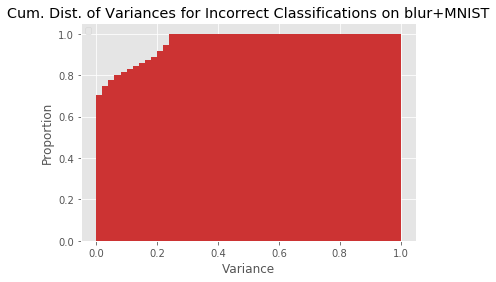

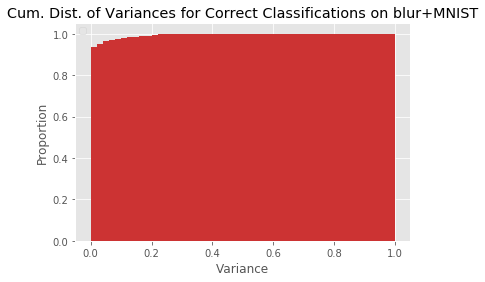

In [169]:
combined_model = get_gp_model[1]()
blur_gp_mu, blur_gp_var = combined_model.predict_batch(blur_feats)
blur_gp_classes = np.argmax(blur_gp_mu, axis=1)
blur_gp_correct = blur_correct_classes == blur_gp_classes

correct_mus, correct_vars = blur_gp_mu[blur_gp_correct], blur_gp_var[blur_gp_correct]
incorrect_mus, incorrect_vars = blur_gp_mu[~blur_gp_correct], blur_gp_var[~blur_gp_correct]

make_histogram(incorrect_vars.reshape(-1), 
               bins=50, 
               end=1.0, 
               density=True, 
               cum=True, 
               x_label="Variance",
               y_label="Proportion", 
               color=[0.8, 0.2, 0.2],
               legend_loc="upper left",
               title="Cum. Dist. of Variances for Incorrect Classifications on blur+MNIST",
               save='../results/figs/nmnist/blur_incorrect_variances_combined.pdf')
plt.show()
make_histogram(correct_vars.reshape(-1), 
               bins=50, 
               end=1.0, 
               density=True, 
               cum=True, 
               x_label="Variance",
               y_label="Proportion", 
               color=[0.8, 0.2, 0.2],
               legend_loc="upper left",
               title="Cum. Dist. of Variances for Correct Classifications on blur+MNIST",
               save='../results/figs/nmnist/blur_correct_variances_combined.pdf')
plt.show()


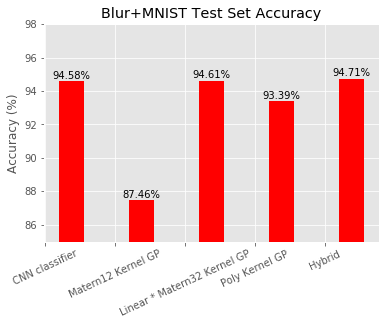

In [174]:
# Plot AWGN NMNIST performance

        
# some manual fiddling to rename then the following
xs, values = list(zip(*list(accuracies.items())))
ind = np.arange(len(xs))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, 100*np.array(values), width, color='r')
autolabel(rects1, ax)
# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy (%)')
ax.set_title('Blur+MNIST Test Set Accuracy')
ax.set_xticks(ind + width / 2 - 0.55)
ax.set_xticklabels(xs)
ax.set_ylim([85.0, 98.0])
plt.xticks(rotation=25)
plt.savefig('../results/figs/nmnist/blur_accuracies.pdf', bbox_inches='tight')
plt.show()

In [176]:
data.dump('_'.join([record_in,  subkey]))

Saved to file, emptying data container


In [175]:
nmnist_noisy_lowcontrast = scipy.io.loadmat('../data/raw/n-mnist/nmnist-contrast.mat')
record_in = 'Low Contrast MNIST'

lowcontrast_x_test = preprocess_images(nmnist_noisy_lowcontrast['test_x'])
lowcontrast_y_test_onehot = nmnist_noisy_lowcontrast['test_y']
lowcontrast_y_test = np.argmax(lowcontrast_y_test_onehot, axis=1)
lowcontrast_correct_classes = lowcontrast_y_test

lowcontrast_feats = cnn_model.extract_features(lowcontrast_x_test)

In [177]:
record_in = 'MNIST + low contrast + AWGN'
subkey = 'Accuracy'

lowcontrast_feats = cnn_model.extract_features(lowcontrast_x_test)

#CNN
lowcontrast_cnn_preds = cnn_model.predict_img_batch(lowcontrast_x_test)
lowcontrast_cnn_classes = np.argmax(lowcontrast_cnn_preds, axis=1)
lowcontrast_cnn_correct = lowcontrast_correct_classes == lowcontrast_cnn_classes
lowcontrast_cnn_accuracy = np.count_nonzero(lowcontrast_cnn_correct) / n
print("CNN accuracy: ", lowcontrast_cnn_accuracy)
data.write([record_in, subkey, cnn_model.name], lowcontrast_cnn_accuracy)

# SVM
lowcontrast_svm_classes = svm_model.predict_batch(lowcontrast_feats)
lowcontrast_svm_correct = lowcontrast_correct_classes == lowcontrast_svm_classes
lowcontrast_svm_accuracy = np.count_nonzero(lowcontrast_svm_correct) / n
print("SVM accuracy: ", lowcontrast_svm_accuracy)
data.write([record_in, subkey, svm_model.name], lowcontrast_svm_accuracy)

CNN accuracy:  0.7715
SVM accuracy:  0.7003


In [178]:
accuracies = {}
accuracies[cnn_model.name] = lowcontrast_cnn_accuracy # save for plotting


# GP
for gp_model_getter in get_gp_model:
    gp_model = gp_model_getter()
    print("Instantiated", gp_model.name)
    lowcontrast_gp_mu, lowcontrast_gp_var = gp_model.predict_batch(lowcontrast_feats)
    lowcontrast_gp_classes = np.argmax(lowcontrast_gp_mu, axis=1)
    lowcontrast_gp_correct = lowcontrast_correct_classes == lowcontrast_gp_classes
    lowcontrast_gp_accuracy = np.count_nonzero(lowcontrast_gp_correct) / n
    print(gp_model.name, "accuracy: ", lowcontrast_gp_accuracy)
    data.write([record_in, subkey, gp_model.name], lowcontrast_gp_accuracy)
    accuracies[gp_model.name] = lowcontrast_gp_accuracy

    for hybrid in hybrid_models:
        name = hybrid.name + "(GP: {})".format(gp_model.name)
        hybrid_pred, hybrid_mus, hybrid_vars = hybrid.combine_predictions(lowcontrast_cnn_preds, lowcontrast_gp_mu, lowcontrast_gp_var)
        hybrid_classes = hybrid_pred[:, 1]
        hybrid_correct = lowcontrast_correct_classes == hybrid_classes
        hybrid_accuracy = np.count_nonzero(hybrid_correct) / n
        print(name, "accuracy:", hybrid_accuracy)
        data.write([record_in, subkey, name], hybrid_accuracy)
        if 'Matern32' in gp_model.name:
            accuracies[hybrid.name] = hybrid_accuracy
    del gp_model # Clear TF session, graph (hopefully)

Initialized Poly Kernel GP
Loading GP model from file ../models/gp/Poly Kernel GP_model.npy
Instantiated Poly Kernel GP
Poly Kernel GP accuracy:  0.8118
Hybrid(GP: Poly Kernel GP) accuracy: 0.8082
Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy
Instantiated Linear * Matern32 Kernel GP
Linear * Matern32 Kernel GP accuracy:  0.7895
Hybrid(GP: Linear * Matern32 Kernel GP) accuracy: 0.7927
Initialized Matern12 Kernel GP
Loading GP model from file ../models/gp/Matern12 Kernel GP_model.npy
Instantiated Matern12 Kernel GP
Matern12 Kernel GP accuracy:  0.7152
Hybrid(GP: Matern12 Kernel GP) accuracy: 0.7276


Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy


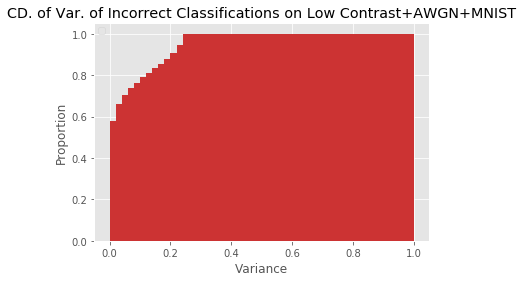

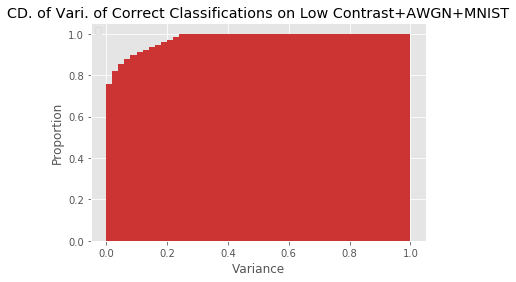

In [179]:
combined_model = get_gp_model[1]()
lowcontrast_gp_mu, lowcontrast_gp_var = combined_model.predict_batch(lowcontrast_feats)
lowcontrast_gp_classes = np.argmax(lowcontrast_gp_mu, axis=1)
lowcontrast_gp_correct = lowcontrast_correct_classes == lowcontrast_gp_classes


correct_mus, correct_vars = lowcontrast_gp_mu[lowcontrast_gp_correct], lowcontrast_gp_var[lowcontrast_gp_correct]
incorrect_mus, incorrect_vars = lowcontrast_gp_mu[~lowcontrast_gp_correct], lowcontrast_gp_var[~lowcontrast_gp_correct]

make_histogram(incorrect_vars.reshape(-1), 
               bins=50, 
               end=1.0, 
               density=True, 
               cum=True, 
               x_label="Variance",
               y_label="Proportion", 
               color=[0.8, 0.2, 0.2],
               legend_loc="upper left",
               title="CD. of Var. of Incorrect Classifications on Low Contrast+AWGN+MNIST",
               save='../results/figs/nmnist/lowcontrast_incorrect_variances_combined.pdf')
plt.show()
make_histogram(correct_vars.reshape(-1), 
               bins=50, 
               end=1.0, 
               density=True, 
               cum=True, 
               x_label="Variance",
               y_label="Proportion", 
               color=[0.8, 0.2, 0.2],
               legend_loc="upper left",
               title="CD. of Vari. of Correct Classifications on Low Contrast+AWGN+MNIST",
               save='../results/figs/nmnist/lowcontrast_correct_variances_combined.pdf')
plt.show()


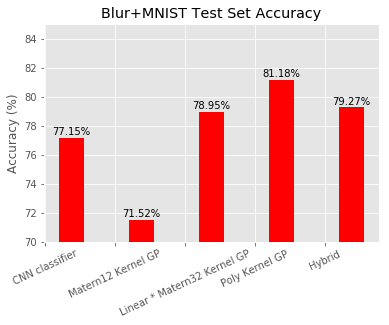

In [180]:
# Plot Low Contrast + AWGN NMNIST performance

        
# some manual fiddling to rename then the following
xs, values = list(zip(*list(accuracies.items())))
ind = np.arange(len(xs))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, 100*np.array(values), width, color='r')
autolabel(rects1, ax)
# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy (%)')
ax.set_title('Blur+MNIST Test Set Accuracy')
ax.set_xticks(ind + width / 2 - 0.55)
ax.set_xticklabels(xs)
ax.set_ylim([70.0, 85.0])
plt.xticks(rotation=25)
plt.savefig('../results/figs/nmnist/lowcontrast_accuracies.pdf', bbox_inches='tight')
plt.show()

In [40]:
data.dump('_'.join([record_in, subkey]))

Saved to file, emptying data container


In [17]:
import gc
gc.collect()

440

In [18]:
record_in = 'FGSM Adverserial MNIST'
#subkey = eps
subkey = 'Accuracy'
#----- Adverserial Examples -----

epsilons = np.arange(0.00, 0.35, 0.025)

plt.style.use('default')

epsilon_accuracies = {}

for eps in epsilons:
    adv_cnn_predictions, perturbed = cnn_model.fgsm_attack(mnist_test_imgs, epsilon=eps)
    adv_cnn_classes = np.argmax(adv_cnn_predictions, axis=1)
    adv_fsgm_features = cnn_model.extract_features(perturbed)
    
#     plt.imshow(perturbed[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
#     plt.savefig('../results/figs/adverserial/fsgm_{}.pdf'.format(eps), bbox_inches='tight')
#     plt.show()
    
    #print("Incorrect: ", np.count_nonzero(correct_classes != adv_cnn_classes))
    print("Epsilon =", eps)    
    
    #CNN performance
    adv_cnn_correct = adv_cnn_classes == correct_classes    
    adv_cnn_accuracy = np.count_nonzero(adv_cnn_correct) / n
    print(cnn_model.name, "accuracy: ", adv_cnn_accuracy)
    data.write([record_in, "epsilon={}".format(eps), cnn_model.name], adv_cnn_accuracy)
    
    # Evaluate SVM 
    adv_svm_preds = svm_model.predict_batch(adv_fsgm_features)
    # SVM performance
    adv_svm_correct = adv_svm_preds == correct_classes
    adv_svm_accuracy = np.count_nonzero(adv_svm_correct) / n
    print(svm_model.name, "accuracy: ", adv_svm_accuracy)
    data.write([record_in, "epsilon={}".format(eps), subkey, svm_model.name], adv_svm_accuracy)
    
                  
    accuracies = {}
    accuracies[cnn_model.name] = adv_cnn_accuracy # save for plotting


    for gp_model_getter in get_gp_model:
        gp_model = gp_model_getter()
        print("Instantiated", gp_model.name)
        # Evaluate GP
        (adv_mu, adv_var) = gp_model.predict_batch(adv_fsgm_features)
        adv_gp_preds = np.argmax(adv_mu, axis=1)
        # GP performance
        adv_gp_correct = correct_classes == adv_gp_preds
        adv_gp_accuracy = np.count_nonzero(adv_gp_correct) / n
        print(gp_model.name, "accuracy: ", adv_gp_accuracy)
        data.write([record_in, "epsilon={0:.3f}".format(eps), subkey, gp_model.name], adv_gp_accuracy)
        accuracies[gp_model.name] = adv_gp_accuracy


#         lowcontrast_gp_mu, lowcontrast_gp_var = gp_model.predict_batch(lowcontrast_feats)
#         lowcontrast_gp_classes = np.argmax(lowcontrast_gp_mu, axis=1)
#         lowcontrast_gp_correct = lowcontrast_correct_classes == lowcontrast_gp_classes
#         lowcontrast_gp_accuracy = np.count_nonzero(lowcontrast_gp_correct) / n
#         print(gp_model.name, "accuracy: ", lowcontrast_gp_accuracy)
#         data.write([record_in, subkey, gp_model.name], lowcontrast_gp_accuracy)

        for hybrid in hybrid_models:
            name = hybrid.name + "(GP: {})".format(gp_model.name)
            hybrid_adv_pred, hybrid_adv_mus, hybrid_adv_vars = hybrid.combine_predictions(adv_cnn_predictions, adv_mu, adv_var)
            hybrid_adv_classes = hybrid_adv_pred[:, 1]
            hybrid_adv_correct = correct_classes == hybrid_adv_classes
            hybrid_adv_accuracy = np.count_nonzero(hybrid_adv_correct) / n
            print(name, "accuracy:", hybrid_adv_accuracy)
            data.write([record_in,  "epsilon={}".format(eps), subkey, name], hybrid_adv_accuracy)
            if 'Matern32' in gp_model.name:
                accuracies[hybrid.name] = hybrid_adv_accuracy
        del gp_model # Clear TF session, graph (hopefully)
    epsilon_accuracies[eps] = accuracies
    data.dump('_'.join([record_in, "eps={}".format(eps), subkey]))
    gc.collect()

Epsilon = 0.0
CNN classifier accuracy:  0.9911
SVM classifier accuracy:  0.9937
Initialized Poly Kernel GP
Loading GP model from file ../models/gp/Poly Kernel GP_model.npy
Instantiated Poly Kernel GP
Poly Kernel GP accuracy:  0.9891
Hybrid(GP: Poly Kernel GP) accuracy: 0.989
Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy
Instantiated Linear * Matern32 Kernel GP
Linear * Matern32 Kernel GP accuracy:  0.9914
Hybrid(GP: Linear * Matern32 Kernel GP) accuracy: 0.9914
Initialized Matern12 Kernel GP
Loading GP model from file ../models/gp/Matern12 Kernel GP_model.npy
Instantiated Matern12 Kernel GP
Matern12 Kernel GP accuracy:  0.9903
Hybrid(GP: Matern12 Kernel GP) accuracy: 0.9903
Saved to file, emptying data container
Epsilon = 0.025
CNN classifier accuracy:  0.9888
SVM classifier accuracy:  0.9905
Initialized Poly Kernel GP
Loading GP model from file ../models/gp/Poly Kernel GP_model.npy
Instantiated Poly Kernel GP
Poly

Poly Kernel GP accuracy:  0.4467
Hybrid(GP: Poly Kernel GP) accuracy: 0.4474
Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy
Instantiated Linear * Matern32 Kernel GP
Linear * Matern32 Kernel GP accuracy:  0.4187
Hybrid(GP: Linear * Matern32 Kernel GP) accuracy: 0.4185
Initialized Matern12 Kernel GP
Loading GP model from file ../models/gp/Matern12 Kernel GP_model.npy
Instantiated Matern12 Kernel GP
Matern12 Kernel GP accuracy:  0.4578
Hybrid(GP: Matern12 Kernel GP) accuracy: 0.456
Saved to file, emptying data container
Epsilon = 0.275
CNN classifier accuracy:  0.3152
SVM classifier accuracy:  0.3146
Initialized Poly Kernel GP
Loading GP model from file ../models/gp/Poly Kernel GP_model.npy
Instantiated Poly Kernel GP
Poly Kernel GP accuracy:  0.3442
Hybrid(GP: Poly Kernel GP) accuracy: 0.3439
Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy
Instantia

In [54]:
(xs, ys) = list(zip(*sorted(list(epsilon_accuracies.items()), key=lambda x: x[0])))


In [57]:
labels = ys[0].keys()
all_points = []
for d in ys:
    tmp = []
    for lab in labels:
        tmp.append(d[lab])
    all_points.append(tmp)
all_points = np.array(all_points).T

[[0.9903 0.986  0.9756 0.9525 0.919  0.8723 0.8081 0.7296 0.6414 0.5502
  0.4578 0.3679 0.2885 0.2197]
 [0.9911 0.9888 0.9749 0.9549 0.9191 0.8682 0.8003 0.7164 0.6216 0.5224
  0.4184 0.3152 0.2332 0.172 ]
 [0.9914 0.9869 0.9765 0.955  0.9196 0.8687 0.8023 0.7193 0.6247 0.5252
  0.4185 0.3154 0.2376 0.1757]
 [0.9891 0.9833 0.971  0.9526 0.9198 0.8739 0.8148 0.7426 0.6567 0.55
  0.4467 0.3442 0.2624 0.1999]
 [0.9914 0.9869 0.9763 0.9549 0.9194 0.8685 0.8022 0.7193 0.6258 0.5268
  0.4187 0.3158 0.2377 0.1759]]


[0.9903 0.986  0.9756 0.9525 0.919  0.8723 0.8081 0.7296 0.6414 0.5502
 0.4578 0.3679 0.2885 0.2197]
[0.9911 0.9888 0.9749 0.9549 0.9191 0.8682 0.8003 0.7164 0.6216 0.5224
 0.4184 0.3152 0.2332 0.172 ]
[0.9914 0.9869 0.9765 0.955  0.9196 0.8687 0.8023 0.7193 0.6247 0.5252
 0.4185 0.3154 0.2376 0.1757]
[0.9891 0.9833 0.971  0.9526 0.9198 0.8739 0.8148 0.7426 0.6567 0.55
 0.4467 0.3442 0.2624 0.1999]
[0.9914 0.9869 0.9763 0.9549 0.9194 0.8685 0.8022 0.7193 0.6258 0.5268
 0.4187 0.3158 0.2377 0.1759]


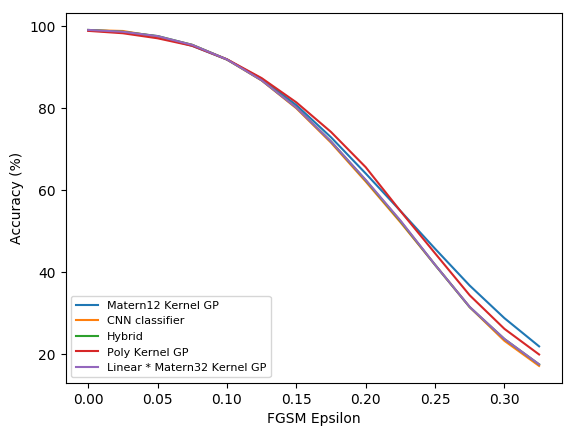

In [64]:
all_points
for pts in all_points:
    print(pts)
    plt.plot(xs, 100*pts)
plt.legend(labels, loc="lower left",
           fontsize=8)
plt.ylabel('Accuracy (%)')
plt.xlabel('FGSM Epsilon')
plt.savefig('../results/figs/adverserial/epsilons.pdf')
plt.show()

In [188]:
# plt.style.use('ggplot')


# eps = 0.2
# adv_cnn_predictions, perturbed = cnn_model.fgsm_attack(mnist_test_imgs, epsilon=eps)
# adv_cnn_classes = np.argmax(adv_cnn_predictions, axis=1)
# adv_fsgm_features = cnn_model.extract_features(perturbed)
    
# print("Epsilon =", eps)    

# #CNN performance
# adv_cnn_correct = adv_cnn_classes == correct_classes    
# adv_cnn_accuracy = np.count_nonzero(adv_cnn_correct) / n
# print(cnn_model.name, "accuracy: ", adv_cnn_accuracy)
# data.write([record_in, "epsilon={}".format(eps), cnn_model.name], adv_cnn_accuracy)

# # Evaluate SVM 
# adv_svm_preds = svm_model.predict_batch(adv_fsgm_features)
# # SVM performance
# adv_svm_correct = adv_svm_preds == correct_classes
# adv_svm_accuracy = np.count_nonzero(adv_svm_correct) / n
# print(svm_model.name, "accuracy: ", adv_svm_accuracy)
# data.write([record_in, "epsilon={}".format(eps), subkey, svm_model.name], adv_svm_accuracy)



              
# for gp_model_getter in get_gp_model:
#     gp_model = gp_model_getter()
#     print("Instantiated", gp_model.name)
#     # Evaluate GP
#     (adv_mu, adv_var) = gp_model.predict_batch(adv_fsgm_features)
#     adv_gp_preds = np.argmax(adv_mu, axis=1)
#     # GP performance
#     adv_gp_correct = correct_classes == adv_gp_preds
#     adv_gp_accuracy = np.count_nonzero(adv_gp_correct) / n
#     print(gp_model.name, "accuracy: ", adv_gp_accuracy)
#     data.write([record_in, "epsilon={0:.3f}".format(eps), subkey, gp_model.name], adv_gp_accuracy)

# #         lowcontrast_gp_mu, lowcontrast_gp_var = gp_model.predict_batch(lowcontrast_feats)
# #         lowcontrast_gp_classes = np.argmax(lowcontrast_gp_mu, axis=1)
# #         lowcontrast_gp_correct = lowcontrast_correct_classes == lowcontrast_gp_classes
# #         lowcontrast_gp_accuracy = np.count_nonzero(lowcontrast_gp_correct) / n
# #         print(gp_model.name, "accuracy: ", lowcontrast_gp_accuracy)
# #         data.write([record_in, subkey, gp_model.name], lowcontrast_gp_accuracy)

#     for hybrid in hybrid_models:
#         name = hybrid.name + "(GP: {})".format(gp_model.name)
#         hybrid_adv_pred, hybrid_adv_mus, hybrid_adv_vars = hybrid.combine_predictions(adv_cnn_predictions, adv_mu, adv_var)
#         hybrid_adv_classes = hybrid_adv_pred[:, 1]
#         hybrid_adv_correct = correct_classes == hybrid_adv_classes
#         hybrid_adv_accuracy = np.count_nonzero(hybrid_adv_correct) / n
#         print(name, "accuracy:", hybrid_adv_accuracy)
#         data.write([record_in,  "epsilon={}".format(eps), subkey, name], hybrid_adv_accuracy)

#     del gp_model # Clear TF session, graph (hopefully)

Epsilon = 0.2
CNN classifier accuracy:  0.6219
SVM classifier accuracy:  0.6243
Initialized Poly Kernel GP
Loading GP model from file ../models/gp/Poly Kernel GP_model.npy
Instantiated Poly Kernel GP
Poly Kernel GP accuracy:  0.6573
Hybrid(GP: Poly Kernel GP) accuracy: 0.6577
Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy
Instantiated Linear * Matern32 Kernel GP
Linear * Matern32 Kernel GP accuracy:  0.6261
Hybrid(GP: Linear * Matern32 Kernel GP) accuracy: 0.625
Initialized Matern12 Kernel GP
Loading GP model from file ../models/gp/Matern12 Kernel GP_model.npy
Instantiated Matern12 Kernel GP
Matern12 Kernel GP accuracy:  0.6416
Hybrid(GP: Matern12 Kernel GP) accuracy: 0.6399


{'CNN classifier': 0.6219, 'Hybrid': 0.625}

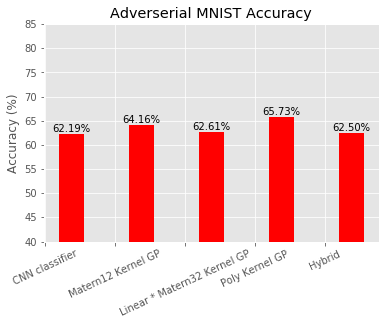

In [195]:
# Plot Adverserial NMNIST performance

        
# some manual fiddling to rename then the following
xs, values = list(zip(*list(accuracies.items())))
ind = np.arange(len(xs))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, 100*np.array(values), width, color='r')
autolabel(rects1, ax)
# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy (%)')
ax.set_title('Adverserial MNIST Accuracy')
ax.set_xticks(ind + width / 2 - 0.55)
ax.set_xticklabels(xs)
ax.set_ylim([40.0, 85.0])
plt.xticks(rotation=25)
plt.savefig('../results/figs/adverserial/accuracies_eps0.2.pdf', bbox_inches='tight')
plt.show()

Initialized Linear * Matern32 Kernel GP
Loading GP model from file ../models/gp/Linear * Matern32 Kernel GP_model.npy


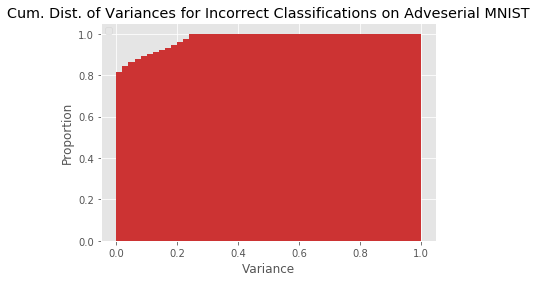

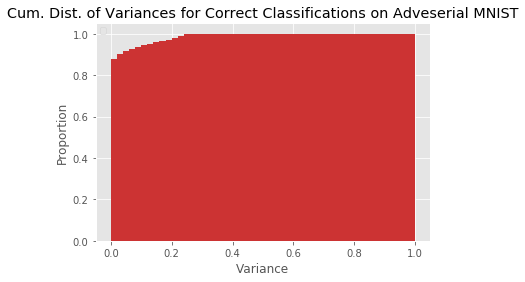

In [196]:
combined_model = get_gp_model[1]()
adv_gp_mu, adv_gp_var = combined_model.predict_batch(adv_fsgm_features)
adv_gp_classes = np.argmax(adv_gp_mu, axis=1)
adv_gp_correct = correct_classes == adv_gp_classes

correct_mus, correct_vars = adv_gp_mu[adv_gp_correct], adv_gp_var[adv_gp_correct]
incorrect_mus, incorrect_vars = adv_gp_mu[~adv_gp_correct], adv_gp_var[~adv_gp_correct]

make_histogram(incorrect_vars.reshape(-1), 
               bins=50, 
               end=1.0, 
               density=True, 
               cum=True, 
               x_label="Variance",
               y_label="Proportion", 
               color=[0.8, 0.2, 0.2],
               legend_loc="upper left",
               title="Cum. Dist. of Variances for Incorrect Classifications on Adveserial MNIST",
               save='../results/figs/adverserial/adv_incorrect_variances_combined_eps0.2.pdf')
plt.show()
make_histogram(correct_vars.reshape(-1), 
               bins=50, 
               end=1.0, 
               density=True, 
               cum=True, 
               x_label="Variance",
               y_label="Proportion", 
               color=[0.8, 0.2, 0.2],
               legend_loc="upper left",
               title="Cum. Dist. of Variances for Correct Classifications on Adveserial MNIST",
               save='../results/figs/adverserial/adv_correct_variances_combined_eps0.2.pdf')
plt.show()
